In [1]:
print("\u03B5")
print("ε")

EPSILON = "\u03B5"

ε
ε


In [2]:
def preprocess_regex(regex):
    ## Add | between characters in square brackets i.e Convert [ab] to (a|b)
    i = 0
    result =""
    while i < len(regex):
        c = regex[i]
    
        if c == '[':
            result += '(' 
            i += 1
            first = True
            
            # Loop until we find ']' or reach the end 
            while i < len(regex) and regex[i] != ']':
                
                # Assuming that nested square brackets are not allowed
                if regex[i] == '[':
                    print("Invalid regex: Nested square brackets are not allowed")
                    return False
                
                if not first:
                    result += '|'
                result += regex[i]
                first = False
                i += 1
            
            # If the loop without finding ] , it's an error.
            if i >= len(regex):
                print("Invalid regex: Unbalanced parentheses (Unclosed square bracket)")
                return False
                
            result += ')'
            
        else:
            result += c
        
        i += 1
    
    if ']' in result:
        print("Invalid regex: Unbalanced parentheses (Closed square bracket)")
        return False
    
    special_operators = ['+' ,'*', '&', '?']
    literals = list("abcdefghijklmnopqrstuvwxyzABCDEFGHIJKLMNOPQRSTUVWXYZ0123456789.")
    
    """ 
    Preprocess the regex to add concatenation character & for NFA construction using postfix between the 2 characters in these cases:
    - literal followed by literal or open bracket
    - closed bracket followed by literal or open bracket
    - special operator followed by literal or open bracket
    """
    formatted_regex = ""
    for i, char in enumerate(result):
        formatted_regex += char
        
        if i + 1 < len(result):
            if ( (char in literals or char ==")") and (result[i+1] in literals or result[i+1] == "(") ) or (char in special_operators and (result[i+1] in literals or result[i+1] == "(") ):
                formatted_regex += "&"
    
    return formatted_regex
            

In [3]:
def shunting_yard(infix):
    preprocessed_infix = preprocess_regex(infix) 
    if preprocessed_infix:
        print(f"Preprocessed: {preprocessed_infix}")
    else:
        return False

    precedence = {
        '*': 5, 
        '+': 4, 
        '?': 3, 
        '&': 2, 
        '|': 1,
        '(': 0,
    }
    
    postfix = ""
    stack = []
    
    for char in preprocessed_infix:
        # if opening bracket, push to the stack, and if square bracket set the flag to true to add  |
        if char =='(':
            stack.append(char)
        
        # if closing square bracket, keep removing from the stack until finding an opening square bracket. If not found, the regex is invalid
        # elif char ==']' :
        #     while stack and stack[-1] != "[":
        #         postfix += stack.pop()
        #     if stack: 
        #         stack.pop()
        #     else:
        #         print("Invalid regex: Unbalanced parentheses (Extra closed square bracket)")
        #         return False
        #     flag = False
            
        # if closing bracket, keep removing from the stack until finding an opening square bracket. If not found, the regex is invalid
        elif char ==')':
            while stack and stack[-1] != "(":
                postfix += stack.pop()
            if stack: 
                stack.pop()
            else: 
                print("Invalid regex: Unbalanced parentheses (Extra closed bracket)")
                return False
                
        ## Check this
        # if another operator was added, keep removing from the stack until the remaining characters have less precedence
        elif char in precedence:
            while (stack and stack[-1] != '(' and 
                   precedence[stack[-1]] >= precedence[char]):
                postfix += stack.pop()
            stack.append(char)
            
        ## See if ? or & need any special handling
        
        else:
            postfix += char
        
    while stack:
        if stack[-1] == '(':
            print("Invalid regex: Unbalanced parentheses (Extra open bracket or square bracket)")
            return False
        postfix += stack.pop()
                
    return postfix


In [4]:
class Edge:
    def __init__(self, source = None, destination = None, label = None):
        self.source = source
        self.destination = destination
        self.label = label
        
    def __repr__(self):
        src_label = "None" if self.source is None else "State"
        dest_label = "None" if self.destination is None else "State"
        return f"Edge({src_label} --[{self.label}]--> {dest_label})"

In [5]:
class State:
    def __init__(self, id = None):
        self.id = id
        self.outgoing_edges = []
        
    def add_edge(self, destination, label):
        new_edge = Edge(self, destination, label)
        self.outgoing_edges.append(new_edge)
        
    def __repr__(self):
        return f"State({self.id})"

In [6]:
class NFA:
    def __init__(self, initial_state, inner_states, accepting_states ):
        self.initial_state = initial_state
        self.accepting_states = accepting_states
        self.inner_states = inner_states

In [7]:
def zero_or_more(stack, id):
    # Only pop 1 NFA from the stack
    nfa = stack.pop()
    
    ## Create 2 new states
    new_start = State("S" + str(id))
    new_end = State("S" + str(id + 1))
    
    """
    Create 4 new edges:
    - one from new start state to old start state
    - one from new start state to new end state
    - one from old end state to new start state
    - one from old end state to new end state
    """
    new_start.add_edge(nfa.initial_state, EPSILON)
    new_start.add_edge(new_end, EPSILON)

    for acc_state in nfa.accepting_states:
        acc_state.add_edge(nfa.initial_state, EPSILON)
        acc_state.add_edge(new_end, EPSILON)

    result_nfa = NFA(
        initial_state=new_start,
        inner_states=[new_start, new_end] + nfa.inner_states,
        accepting_states=[new_end] 
    )
    
    return result_nfa, id + 2

In [8]:
def one_or_more(stack, counter_id):
    # Only pop 1 NFA from the stack
    nfa = stack.pop()
    
    ## Create 2 new states
    new_start = State("S" + str(counter_id))
    new_end = State("S" + str(counter_id + 1))
    
    """
    Create 4 new edges:
    - one from new start state to old start state
    - one from old end state to new start state
    - one from old end state to new end state
    """
    new_start.add_edge(nfa.initial_state, EPSILON)

    for acc_state in nfa.accepting_states:
        acc_state.add_edge(nfa.initial_state, EPSILON)
        acc_state.add_edge(new_end, EPSILON)

    result_nfa = NFA(
        initial_state=new_start,
        inner_states=[new_start, new_end] + nfa.inner_states,
        accepting_states=[new_end] 
    )
    
    return result_nfa, counter_id + 2

In [9]:
def zero_or_one(stack, counter_id):
    # Only pop 1 NFA from the stack
    nfa = stack.pop()
    
    ## Create 2 new states
    new_start = State("S" + str(counter_id))
    new_end = State("S" + str(counter_id + 1))
    
    """
    Create 3 new edges:
    - one from new start state to old start state
    - one from new start state to new end state
    - one from old end state to new end state
    """
    new_start.add_edge(nfa.initial_state, EPSILON)
    new_start.add_edge(new_end, EPSILON)

    for acc_state in nfa.accepting_states:
        acc_state.add_edge(new_end, EPSILON)

    result_nfa = NFA(
        initial_state=new_start,
        inner_states=[new_start, new_end] + nfa.inner_states,
        accepting_states=[new_end] 
    )
    
    return result_nfa, counter_id + 2

In [10]:
def concat(stack):
    # Pop 2 NFAs from the stack
    end_nfa = stack.pop()
    start_nfa = stack.pop()
    
    ## Add an edge from the accepting states of the first NFA to the second one
    for acc_state in start_nfa.accepting_states:
        acc_state.add_edge(end_nfa.initial_state, EPSILON)
             
    result_nfa = NFA(
        initial_state=start_nfa.initial_state,
        inner_states=start_nfa.inner_states + end_nfa.inner_states,
        accepting_states= end_nfa.accepting_states
    )
    
    return result_nfa

In [11]:
def oring(stack, counter_id):
    ## Create 2 new states
    new_start = State("S" + str(counter_id))
    new_end = State("S" + str(counter_id + 1))
    
    ## Pop 2 NFAs from the stack
    first_nfa = stack.pop()
    second_nfa = stack.pop()
    
    ## Add 2 edges (from the new start state to the old start ones)
    new_start.add_edge(first_nfa.initial_state, EPSILON)
    new_start.add_edge(second_nfa.initial_state, EPSILON)
    
    ## Add an edge for each of the old ending states to the new ones
    for acc_state in first_nfa.accepting_states:
        acc_state.add_edge(new_end, EPSILON)
        
    for acc_state in second_nfa.accepting_states:
        acc_state.add_edge(new_end, EPSILON)
        
    result_nfa = NFA(
        initial_state=new_start,
        inner_states=[new_start, new_end] + first_nfa.inner_states + second_nfa.inner_states,
        accepting_states=[new_end] 
    )
    
    return result_nfa, counter_id + 2

In [12]:
def create_nfa(c, counter_id):
    ## Create 2 new states
    new_start = State("S" + str(counter_id))
    new_end = State("S" + str(counter_id + 1))
    
    # Create an edge connecting both states with the character as a label
    new_start.add_edge(new_end, c)
    
    new_nfa = NFA(
        initial_state=new_start,
        inner_states=[new_start, new_end],
        accepting_states=[new_end]
    )
    
    return new_nfa, counter_id + 2

In [13]:
def construct_nfa(postfix):
    stack = []
    counter = 0
    
    for char in postfix:
        if char == "&":
            new_nfa = concat(stack)
        elif char == "|":
            new_nfa, counter = oring(stack, counter)
        elif char == '+':
            new_nfa, counter = one_or_more(stack, counter)
        elif char =='*':
            new_nfa, counter = zero_or_more(stack, counter)
        elif char == '?':
            new_nfa, counter = zero_or_one(stack, counter)
        else:
            new_nfa, counter = create_nfa(char, counter)
        
        stack.append(new_nfa)
        
    if stack:
        return stack.pop()
    else:
        print("An error occurred while creating NFA")
        return False

In [14]:
import json

def export_nfa_to_json(nfa, filename="nfa_output.json"):
    """
    Exports an NFA object to a JSON file with proper list handling for non-determinism.
    """
    # Dictionary to hold the final JSON structure
    nfa_dict = {}
    
    # 1. Set the Starting State
    nfa_dict["startingState"] = str(nfa.initial_state.id)
    
    # 2. Traverse the Graph to find all states (BFS)
    queue = [nfa.initial_state]
    visited = set()
    visited.add(nfa.initial_state)
    
    while queue:
        current_state = queue.pop(0)
        state_id = str(current_state.id)
        
        # Prepare the object for this specific state
        state_data = {
            "isTerminatingState": current_state in nfa.accepting_states
        }
        
        # Process all outgoing edges (Transitions)
        for edge in current_state.outgoing_edges:
            label = edge.label
            dest_id = str(edge.destination.id)
            
            # --- THE FIX: HANDLE LISTS VS STRINGS ---
            if label in state_data:
                # We found another transition for the same input (Non-Determinism)
                existing_target = state_data[label]
                
                if isinstance(existing_target, list):
                    # It is already a list, append the new destination if it's not there
                    if dest_id not in existing_target:
                        existing_target.append(dest_id)
                else:
                    # It is currently a string (single target). 
                    # Upgrade it to a list containing both.
                    if existing_target != dest_id:
                        state_data[label] = [existing_target, dest_id]
            else:
                # First time seeing this label for this state.
                # We start it as a String. It will upgrade to a List later if needed.
                state_data[label] = dest_id
            
            # Add destination to queue if we haven't visited it yet
            if edge.destination not in visited:
                visited.add(edge.destination)
                queue.append(edge.destination)
                
        # Add this state to the main dictionary
        nfa_dict[state_id] = state_data

    # 3. Write to file
    # ensure_ascii=False ensures that the Greek epsilon (ε) prints correctly
    with open(filename, "w", encoding='utf-8') as f:
        json.dump(nfa_dict, f, indent=4, ensure_ascii=False)
        
    return json.dumps(nfa_dict, indent=4, ensure_ascii=False)

In [15]:
postfix = shunting_yard("(a|b)*abb")
nfa = construct_nfa(postfix)
export_nfa_to_json(nfa)

Preprocessed: (a|b)*&a&b&b


'{\n    "startingState": "S6",\n    "S6": {\n        "isTerminatingState": false,\n        "ε": [\n            "S4",\n            "S7"\n        ]\n    },\n    "S4": {\n        "isTerminatingState": false,\n        "ε": [\n            "S2",\n            "S0"\n        ]\n    },\n    "S7": {\n        "isTerminatingState": false,\n        "ε": "S8"\n    },\n    "S2": {\n        "isTerminatingState": false,\n        "b": "S3"\n    },\n    "S0": {\n        "isTerminatingState": false,\n        "a": "S1"\n    },\n    "S8": {\n        "isTerminatingState": false,\n        "a": "S9"\n    },\n    "S3": {\n        "isTerminatingState": false,\n        "ε": "S5"\n    },\n    "S1": {\n        "isTerminatingState": false,\n        "ε": "S5"\n    },\n    "S9": {\n        "isTerminatingState": false,\n        "ε": "S10"\n    },\n    "S5": {\n        "isTerminatingState": false,\n        "ε": [\n            "S4",\n            "S7"\n        ]\n    },\n    "S10": {\n        "isTerminatingState": false,\n

Loaded NFA with 14 states.
Graph generated: nfa_visualization.png


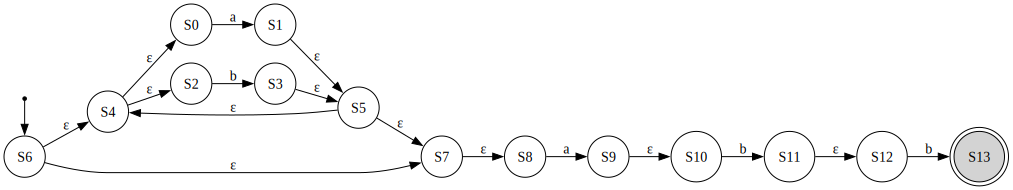

3. Converting NFA to DFA...
   -> Generated DFA with 5 states.
4. Visualizing DFA...
   -> Image saved to: dfa_graph.png
5. DFA JSON Output:
{
    "startingState": "S0",
    "S0": {
        "isTerminatingState": false,
        "a": "S1",
        "b": "S2"
    },
    "S1": {
        "isTerminatingState": false,
        "a": "S1",
        "b": "S3"
    },
    "S2": {
        "isTerminatingState": false,
        "a": "S1",
        "b": "S2"
    },
    "S3": {
        "isTerminatingState": false,
        "a": "S1",
        "b": "S4"
    },
    "S4": {
        "isTerminatingState": true,
        "a": "S1",
        "b": "S2"
    }
}
   -> Saved to json file
Minimized DFA has 4 states.
4. Visualizing Min-DFA...
   -> Image saved to: min_dfa_graph.png
5. MIN_DFA JSON Output:
{
    "startingState": "S0",
    "S0": {
        "isTerminatingState": false,
        "a": "S1",
        "b": "S0"
    },
    "S1": {
        "isTerminatingState": false,
        "a": "S1",
        "b": "S2"
    },
    "S2

In [16]:
import DFA_Builder
DFA_Builder.BuildDFA("nfa_output.json", "DFA/sample_3_DFA.json", "MinDFA/sample_3_MinDFA.json")